Main_Quest_CR8

# 의료영상 U-Net 용종검출 Part 1
# 노드의 두 기본 모델 성능 비교

* Decoder-Encoder model
* U-Net model

---

#### 학습목표

* 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델을 만들어 본다.
* 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해 본다.
* Encoder-Decoder Model과 U-net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다.
* U-Net에 pretrained encoder를 적용하여 성능개선을 확인해 본다.

평가문항 및 상세기준
1. 의료영상 데이터의 전처리 및 augmentation을 위한 파이프라인 구성이 체계적으로 진행되었는가?

    [o] __augmentation이 반영된 tf.data.Dataset 구성__이 정상적으로 진행되었다.
    
    
2. U-Net의 개선 모델을 구현하여 적용 후 기존 U-Net 대비 성능 개선을 확인하였는가?

    [1/3 진행중] __U-Net 개선 모델의 학습__ 과정이 정상적으로 진행되었으며, __validation meanIoU가 기존 U-Net보다 좋아짐__ 을 확인하였다.
    

3. 3가지 모델에 대한 학습과정, 테스트 결과를 체계적으로 비교분석하였는가?

    [1/3 진행중] _loss 그래프, meanIoU 계산, segmentation 결과 시각화_ 등이 __3가지 모델에 대해 수행된 후 결과 비교분석__ 이 제시되었다.

# Part 1

## 01. 데이터 수집 및 Visualization

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
# DATASET_PATH = 'medical'

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

데이터셋 :
* 이미지 디렉토리 (train)
* 라벨 디렉토리 (train_labels)

파일명 : 쌍을 이루는 이미지, 라벨의 파일명은 동일

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


* 데이터가 희소하므로 증강이 필수적이다.

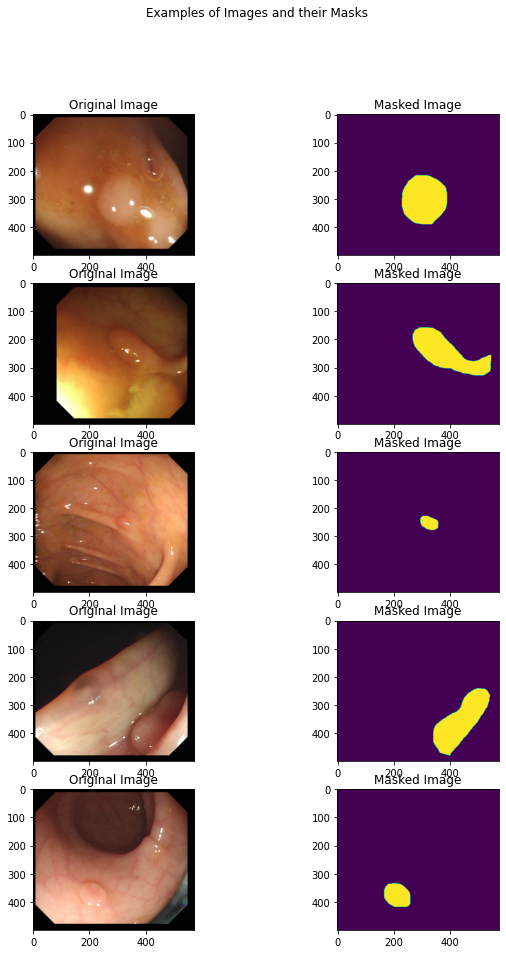

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

* 라벨 데이터 : 이미지 (원본과 동일 사이즈, 1채널)

## 02. Data pipeline and Preprocessing

02-1. 하이퍼 파라미터 세팅

In [20]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
# batch_size = 4
max_epochs = 10

02-2. 입력 파이프라인 설계 (tf.data를 활용)

* 데이터셋 구축
* 배치 처리
* 데이터 증강

In [9]:
# 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
# 바이트를 이미지 형식으로 디코딩합니다.

# 이미지 데이터 로드하는 함수
# 수행 작업 : byte 형태로 데이터 로드, bmp로 디코드, 스케일과 사이즈 조정

def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [10]:
# 증강1 : 이동
# 이미지 위치를 적절히 이동시키는 함수 (입력과 라벨 동일하게 이동)

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
# 증강2 : 좌우반전 (50%에 적용), 상하반전 미적용

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
# _augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)

# 위의 두 가지 증강 기법 및 색 변환, 사이즈 조정 등 증강을 데이터에 적용하는 함수
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [13]:
# 데이터 섞고 반복 학습

# tf.data.Dataset을 사용해 배치구성 및 셔플링
# 증강도 적용하되, 훈련 데이터셋에만 적용

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

적용된 모습을 확인해보자.

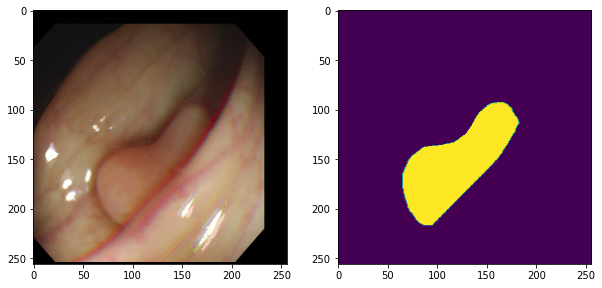

In [15]:
# 구성된 학습 데이터 확인
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 03. Build the model

* Encoder-Decoder 스타일 네트워크
* U-Net

### 03-1. Encoder-Decoder

#### Encoder
* input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.
    * inputs = [batch_size, 256, 256, 3]
    * conv1 = [batch_size, 128, 128, 64]
    * conv2 = [batch_size, 64, 64, 128]
    * conv3 = [batch_size, 32, 32, 256]
    * outputs = [batch_size, 16, 16, 512]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.
* Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.
* tf.keras.Sequential()을 이용하여 만들어 봅시다.
#### Decoder
* Encoder의 mirror 형태로 만들어 봅시다.
* input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.
    * inputs = encoder의 outputs = [batch_size, 16, 16, 512]
    * conv_transpose1 = [batch_size, 32, 32, 256]
    * conv_transpose2 = [batch_size, 64, 64, 128]
    * conv_transpose3 = [batch_size, 128, 128, 64]
    * outputs = [batch_size, 256, 256, 1]
* tf.keras.Sequential()을 이용하여 만들어 봅시다.

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [24]:
# %reset
# 리소스 문제가 있으나 이로 해결되지 않아서 커널 재시작, 해결됨

In [21]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [22]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [23]:
# 인코더-디코더 결합한 모델 만들기

ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### 03-2. U-Net

In [25]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [26]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [27]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [28]:
# 클래스들을 결합해 최종 U-Net 모델 구현
unet_model = UNet()

In [29]:
# (meanIoU를 올리도록)
# Cross-entropy loss 와 Dice loss함께 사용
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

# dice loss가 최대화 되는 방향으로 구해지도록
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# (새로운 loss fn을 사용하기 위해서)
# 기존에 사용했던 binary crossentropy loss + dice loss
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [30]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

## 04. Select a model, compile, use callbacks

### 04-1. 인코더-디코더 모델

In [48]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


In [49]:
# Compile
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16, 16, 512)       4693056   
_________________________________________________________________
decoder (Sequential)         (None, 256, 256, 1)       2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [51]:
# Callbacks
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [52]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### 04-2. U-Net 모델

U-Net 원본과 여기서 구현하는 모델의 차이 : 
* same padding
* Encoder-Decoder 대응하는 레이어 사이즈 유지

(모델 개선이 용이해진다)

---

U-Net과 Encoder-Decoder 모델의 주된 차이 : 
* U-Net은 엔드-투-엔드 방식이 아니라서 시퀀셜 모듈을 사용할 수 없고, 함수형 API를 사용한다.
    * Model Subclassing 방식 사용
    * 케라스의 Model 클래스를 상속해 구현

In [71]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [72]:
# Compile
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [73]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [74]:
# Callbacks
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [75]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 05. Train your model

### 05-1. Encoder-Decoder model

In [54]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [55]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 8s 117ms/step - loss: 1.0738 - dice_loss: 0.7758 - val_loss: 59059.9414 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 3s 105ms/step - loss: 0.9882 - dice_loss: 0.7586 - val_loss: 63.3046 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 5s 106ms/step - loss: 0.9938 - dice_loss: 0.7739 - val_loss: 14.1200 - val_dice_loss: 0.9985
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 3s 106ms/step - loss: 0.9647 - dice_loss: 0.7439 - val_loss: 6.1851 - v

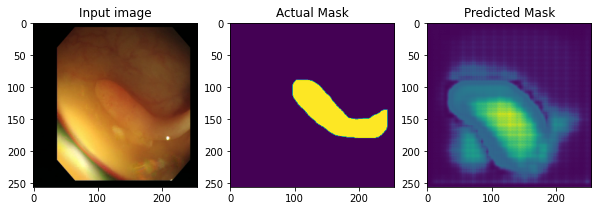

In [56]:
# print sample image after training
print_images()

### Restore the last checkpoint

In [57]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
# checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset

In [58]:
# meanIoU = Area of Overlap / Area of Union
# (세그멘테이션 정량적 평가 메트릭, 불러온 가중치를 이용해서 모델 평가)
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [59]:
# 테스트 데이터셋의 meanIoU 값 (우리가 훈련시킨 모델에 대한 정량적 성능 metric) 구하기
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.6766881528946629


In [60]:
# # 확인하는 함수
# ## Define print function
# def print_images():
#     for test_images, test_labels in test_dataset.take(1):
#         predictions = model(test_images, training=False)

#         for i in range(batch_size):
#             plt.figure(figsize=(10, 20))
#             plt.subplot(1, 3, 1)
#             plt.imshow(test_images[i,: , :, :])
#             plt.title("Input image")

#             plt.subplot(1, 3, 2)
#             plt.imshow(test_labels[i, :, :, 0])
#             plt.title("Actual Mask")

#             plt.subplot(1, 3, 3)
#             plt.imshow(predictions[i, :, :, 0])
#             plt.title("Predicted Mask")
#             plt.show()

In [66]:
# print_images() # Encoder-Decoder 결과

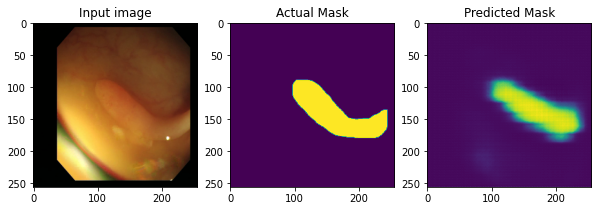

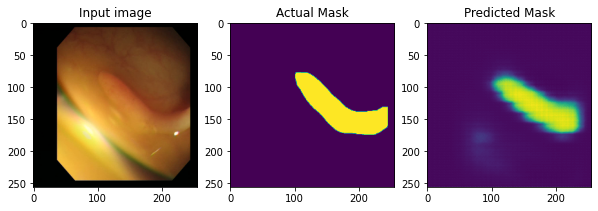

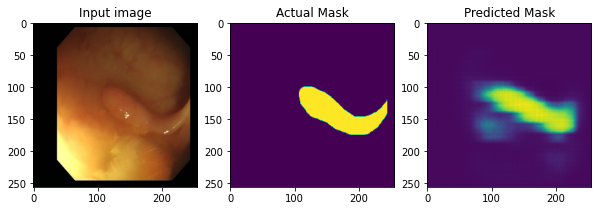

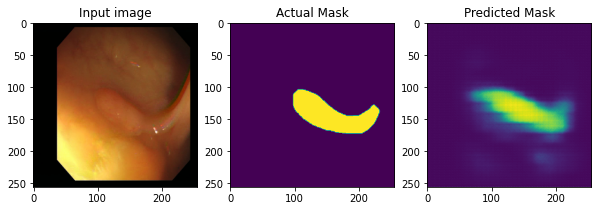

In [62]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        # Get the actual number of images in the current batch
        actual_batch_size = test_images.shape[0]

        for i in range(actual_batch_size):  # Ensure we only loop through valid indices
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

# Call the function
print_images() # Encoder-Decoder 모델 결과

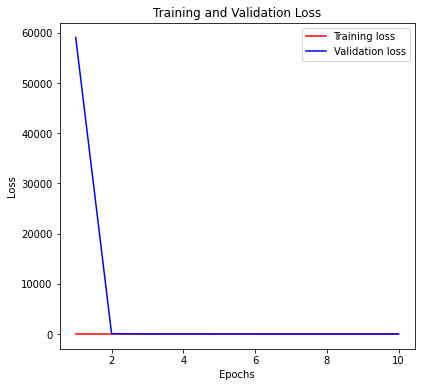

In [63]:
import matplotlib.pyplot as plt

# 히스토리에서 손실 값 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

# 히스토리에서 정확도 값 가져오기 (모델에 따라 'accuracy' 대신 다른 이름일 수 있음)
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')

# 에포크 값 생성
epochs = range(1, len(loss) + 1)

# 손실 그래프 그리기
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 러닝 커브 (정확도 그래프) 그리기
if acc is not None and val_acc is not None:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()

### 05-2. U-Net model

In [36]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [76]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 18s 476ms/step - loss: 0.3795 - dice_loss: 0.2841 - val_loss: 5.5251 - val_dice_loss: 0.7149
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 14s 471ms/step - loss: 0.4336 - dice_loss: 0.3265 - val_loss: 4.6402 - val_dice_loss: 0.6149
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 15s 462ms/step - loss: 0.3561 - dice_loss: 0.2692 - val_loss: 2.1380 - val_dice_loss: 0.9395
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 14s 461ms/step - loss: 0.3134 - dice_loss: 0.2386 - val_loss: 1.3412 - val

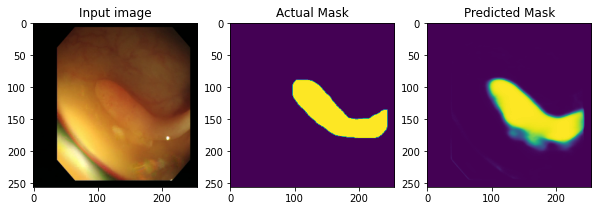

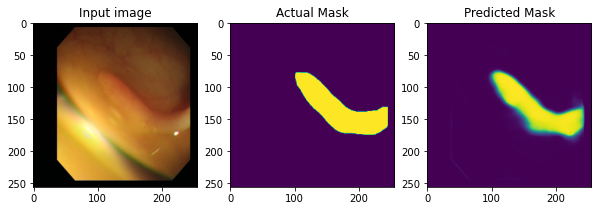

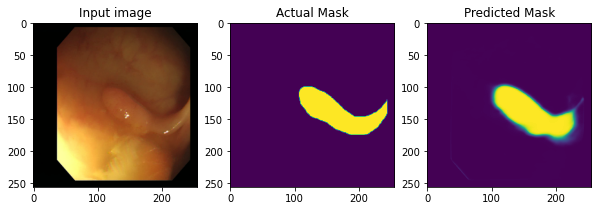

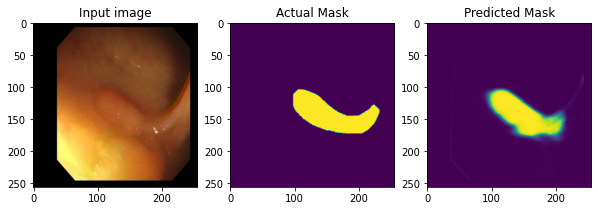

In [77]:
# print sample image after training
print_images()

### Restore the latest checkpoint

In [78]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset

In [42]:
# meanIoU = Area of Overlap / Area of Union
# (세그멘테이션 정량적 평가 메트릭, 불러온 가중치를 이용해서 모델 평가)
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [43]:
# 테스트 데이터셋의 meanIoU 값 (우리가 훈련시킨 모델에 대한 정량적 성능 metric) 구하기
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9432642149571431


In [67]:
# # 확인하는 함수
# ## Define print function
# def print_images():
#     for test_images, test_labels in test_dataset.take(1):
#         predictions = model(test_images, training=False)

#         for i in range(batch_size):
#             plt.figure(figsize=(10, 20))
#             plt.subplot(1, 3, 1)
#             plt.imshow(test_images[i,: , :, :])
#             plt.title("Input image")

#             plt.subplot(1, 3, 2)
#             plt.imshow(test_labels[i, :, :, 0])
#             plt.title("Actual Mask")

#             plt.subplot(1, 3, 3)
#             plt.imshow(predictions[i, :, :, 0])
#             plt.title("Predicted Mask")
#             plt.show()

In [68]:
# print_images() # U-Net 결과

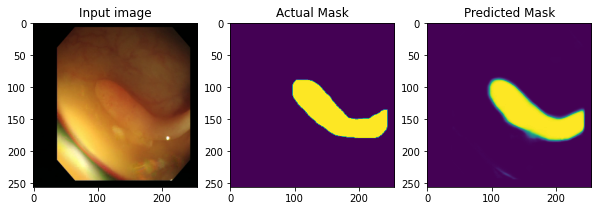

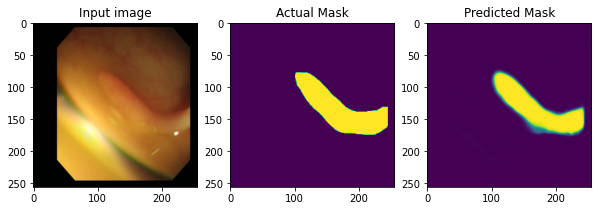

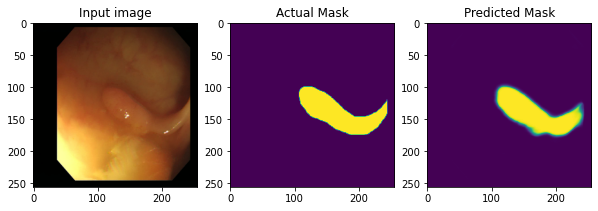

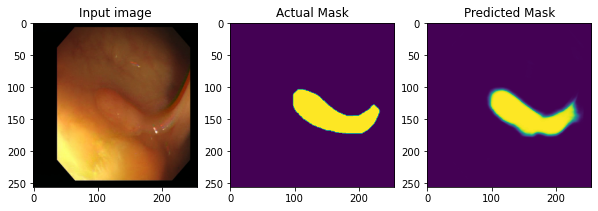

In [47]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        # Get the actual number of images in the current batch
        actual_batch_size = test_images.shape[0]

        for i in range(actual_batch_size):  # Ensure we only loop through valid indices
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

# Call the function
print_images() # U-Net 결과

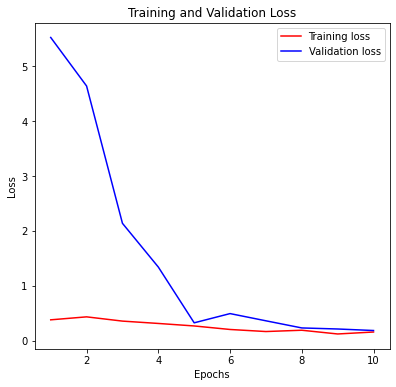

In [79]:
import matplotlib.pyplot as plt

# 히스토리에서 손실 값 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

# 히스토리에서 정확도 값 가져오기 (모델에 따라 'accuracy' 대신 다른 이름일 수 있음)
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')

# 에포크 값 생성
epochs = range(1, len(loss) + 1)

# 손실 그래프 그리기
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 러닝 커브 (정확도 그래프) 그리기
if acc is not None and val_acc is not None:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()


## 06. 프로젝트: U-Net 성능 개선해 보기

[] U-Net의 인코더 모델을 VGG, ResNet 등 기존의 pretrained model을 활용하는 것은 가능할까?

[] 그런 시도를 했을 때 성능 개선 효과가 있을까?

성능개선: Part 2

---

Part 1 회고:
* Encoder-Decoder 모델 대비 U-Net의 세그멘테이션 성능을 비교해봤다.
* meanIoU 값도 각각 0.68, 0.94로 같은 데이터에 대하여 큰 성능 차이를 보여주었고, 육안으로도 차이가 관찰 가능했다.
